<a href="https://colab.research.google.com/github/SurniDaiman/UTS-ML/blob/main/Prediksi_Harga_Properti_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================
# 1. DATA PREPARATION
# ==============================================================

# --- Import Library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib  # untuk menyimpan model
import warnings
warnings.filterwarnings("ignore")

# --- Load Dataset ---
df = pd.read_csv("/content/dataset_properti.csv", sep=";")

# --- Bersihkan Nama Kolom ---
df.columns = df.columns.str.strip()

print("Nama kolom dataset:", df.columns.tolist())
print("\nJumlah data:", df.shape)
print(df.head())

Nama kolom dataset: ['Luas_Tanah_m2', 'Luas_Bangunan_m2', 'Kamar_Tidur', 'Umur_Bangunan_tahun', 'Jarak_Pusat_Kota_km', 'Harga_Properti_juta']

Jumlah data: (200, 6)
   Luas_Tanah_m2  Luas_Bangunan_m2  Kamar_Tidur  Umur_Bangunan_tahun  \
0          21854             26755            1                   30   
1          47782              6113            1                    7   
2           3794               898            1                    6   
3           3194             36247            4                   25   
4          12021             25438            1                   25   

   Jarak_Pusat_Kota_km  Harga_Properti_juta  
0                  775                21689  
1                 1333                22399  
2                 1011                 2369  
3                  121                72308  
4                  150                20609  



=== Statistical Summary ===
       Luas_Tanah_m2  Luas_Bangunan_m2  Kamar_Tidur  Umur_Bangunan_tahun  \
count     200.000000        200.000000   200.000000           200.000000   
mean    21621.520000      19035.265000     3.105000            15.920000   
std     15085.271762      11870.949664     1.515075             8.890942   
min       666.000000        334.000000     1.000000             0.000000   
25%      7848.750000       7159.750000     2.000000             9.000000   
50%     19010.500000      18963.000000     3.000000            16.000000   
75%     34922.000000      28827.500000     5.000000            24.000000   
max     49354.000000      39649.000000     5.000000            30.000000   

       Jarak_Pusat_Kota_km  Harga_Properti_juta  
count           200.000000            200.00000  
mean            997.700000          54384.01500  
std             569.859173          30721.20914  
min              11.000000           2000.00000  
25%             490.500000          

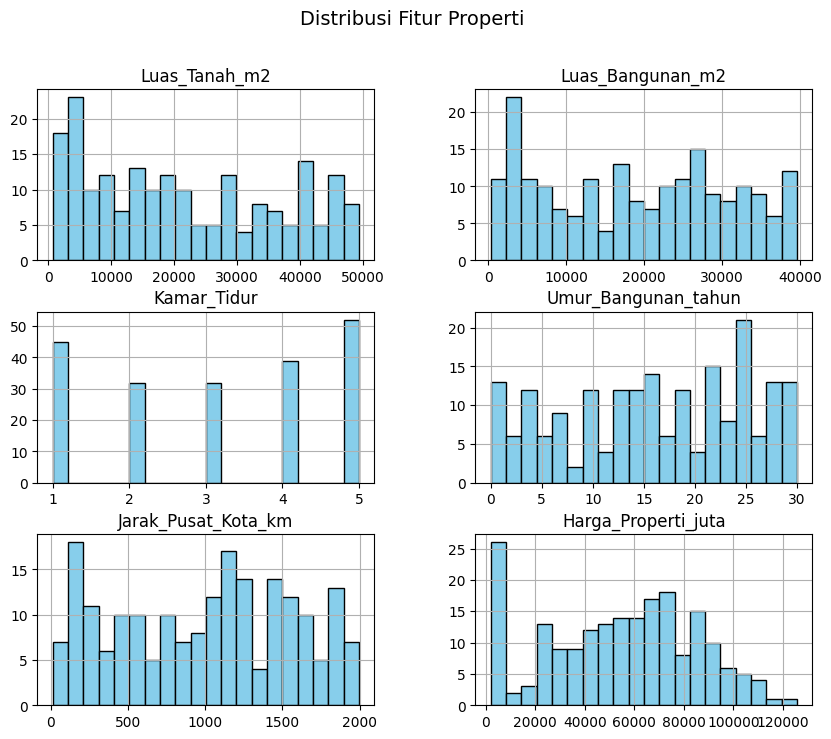

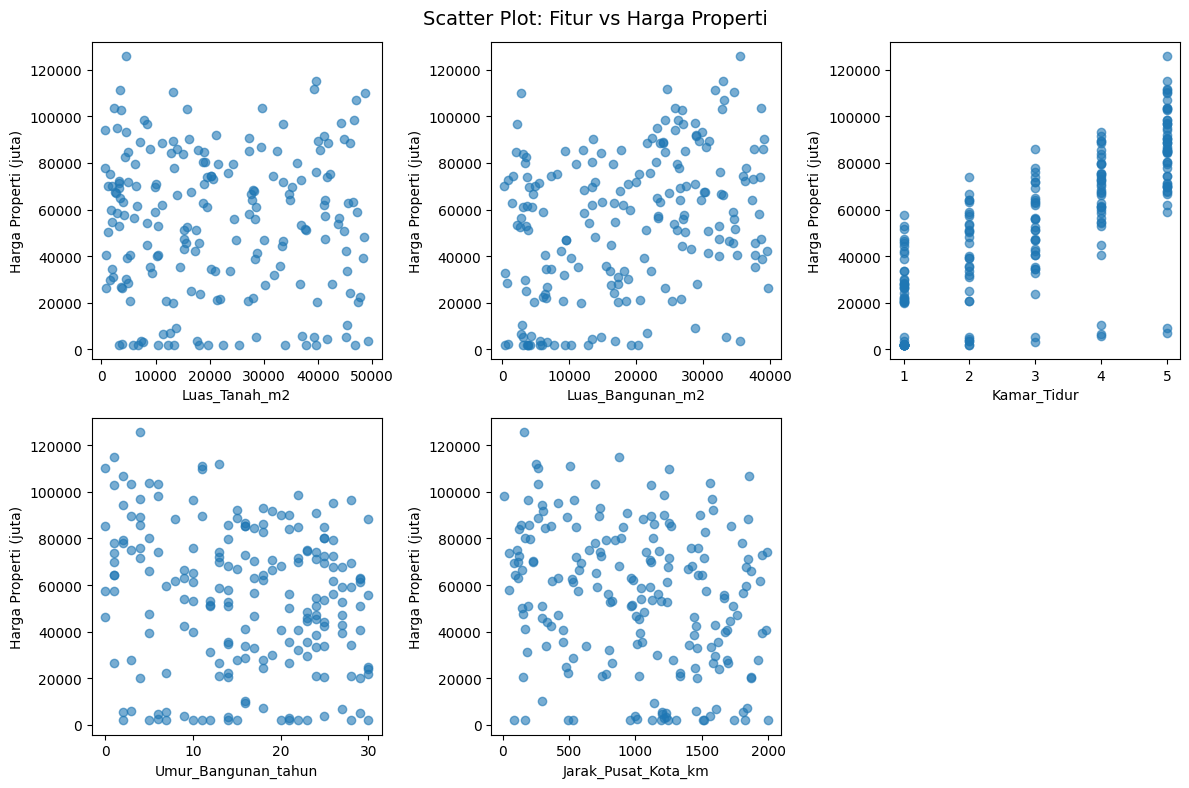

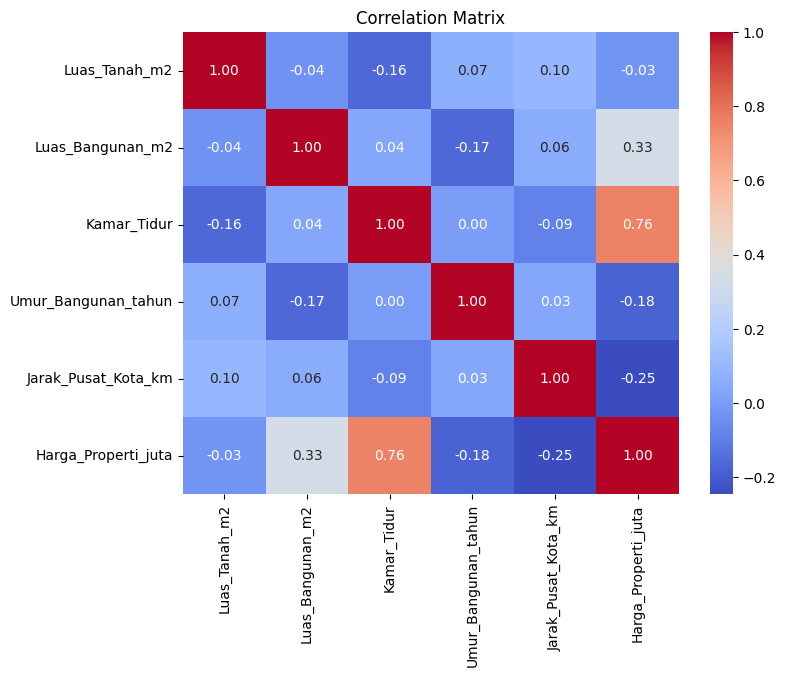


Missing Values:
 Luas_Tanah_m2          0
Luas_Bangunan_m2       0
Kamar_Tidur            0
Umur_Bangunan_tahun    0
Jarak_Pusat_Kota_km    0
Harga_Properti_juta    0
dtype: int64


In [ ]:
# ==============================================================
# 1B. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================

print("\n=== Statistical Summary ===")
print(df.describe())

# --- Visualisasi Distribusi Fitur ---
df.hist(figsize=(10,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribusi Fitur Properti", fontsize=14)
plt.show()

# --- Scatter Plot: setiap fitur vs Harga Properti ---
features = ["Luas_Tanah_m2", "Luas_Bangunan_m2", "Kamar_Tidur", "Umur_Bangunan_tahun", "Jarak_Pusat_Kota_km"]
plt.figure(figsize=(12,8))
for i, col in enumerate(features, 1):
    plt.subplot(2,3,i)
    plt.scatter(df[col], df["Harga_Properti_juta"], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel("Harga Properti (juta)")
plt.suptitle("Scatter Plot: Fitur vs Harga Properti", fontsize=14)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# --- Cek Missing Values & Outliers ---
print("\nMissing Values:\n", df.isnull().sum())

In [ ]:
# ==============================================================
# 1C. DATA PREPROCESSING
# ==============================================================

# --- Pisahkan Fitur dan Target ---
X = df[features]
y = df["Harga_Properti_juta"]

# --- Split Data Train-Test (70:30) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")  # simpan scaler

['scaler.pkl']

In [ ]:
# ==============================================================
# 2. MODEL IMPLEMENTATION
# ==============================================================

from sklearn.pipeline import make_pipeline

degrees = [1, 2, 3, 4, 5]
alphas = [0.1, 1, 10]
results = []

for d in degrees:
    # Polynomial Feature
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    print(f"Degree {d} - Jumlah Fitur: {X_train_poly.shape[1]}")

    # --- Linear Regression ---
    lin = LinearRegression().fit(X_train_poly, y_train)
    y_train_pred = lin.predict(X_train_poly)
    y_test_pred = lin.predict(X_test_poly)

    results.append({
        "Degree": d, "Model": "Linear",
        "R2_Train": r2_score(y_train, y_train_pred),
        "R2_Test": r2_score(y_test, y_test_pred),
        "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_test_pred))
    })

    # --- Ridge Regression ---
    for a in alphas:
        ridge = Ridge(alpha=a).fit(X_train_poly, y_train)
        y_pred = ridge.predict(X_test_poly)
        results.append({
            "Degree": d, "Model": f"Ridge α={a}",
            "R2_Train": ridge.score(X_train_poly, y_train),
            "R2_Test": ridge.score(X_test_poly, y_test),
            "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_pred))
        })

    # --- Lasso Regression ---
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000).fit(X_train_poly, y_train)
        y_pred = lasso.predict(X_test_poly)
        results.append({
            "Degree": d, "Model": f"Lasso α={a}",
            "R2_Train": lasso.score(X_train_poly, y_train),
            "R2_Test": lasso.score(X_test_poly, y_test),
            "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_pred))
        })

df_results = pd.DataFrame(results)
print("\n=== HASIL PERBANDINGAN MODEL ===")
display(df_results)


Degree 1 - Jumlah Fitur: 6
Degree 2 - Jumlah Fitur: 21
Degree 3 - Jumlah Fitur: 56
Degree 4 - Jumlah Fitur: 126
Degree 5 - Jumlah Fitur: 252

=== HASIL PERBANDINGAN MODEL ===


,Degree,Model,R2_Train,R2_Test,RMSE_Test
0,1,Linear,0.715329,0.788032,14025.339564
1,1,Ridge α=0.1,0.715328,0.787972,14027.329686
2,1,Ridge α=1,0.715293,0.787398,14046.323751
3,1,Ridge α=10,0.712175,0.778884,14324.811976
4,1,Lasso α=0.1,0.715329,0.788032,14025.358336
5,1,Lasso α=1,0.715329,0.788027,14025.527392
6,1,Lasso α=10,0.715328,0.787975,14027.236898
7,2,Linear,0.742643,0.783587,14171.633653
8,2,Ridge α=0.1,0.742642,0.783627,14170.353705
9,2,Ridge α=1,0.742587,0.783873,14162.275668



=== METRIC TRAIN ===
{'R2': 0.8068093573877249, 'MSE': 182309340.947921, 'RMSE': np.float64(13502.197634012065), 'MAE': 9590.410155000844, 'MAPE': np.float64(74.69990290587785)}

=== METRIC TEST ===
{'R2': 0.5738278612418377, 'MSE': 395496276.772148, 'RMSE': np.float64(19887.08819239629), 'MAE': 14605.289874301925, 'MAPE': np.float64(139.26872627657255)}


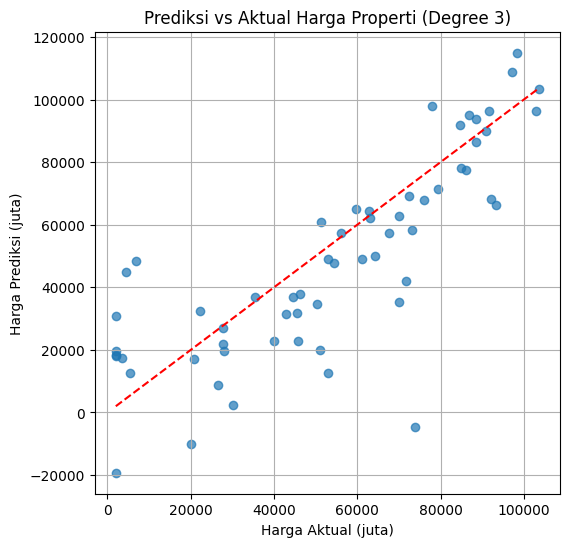

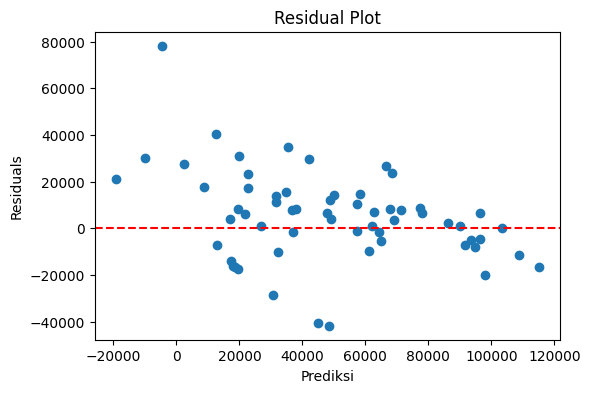

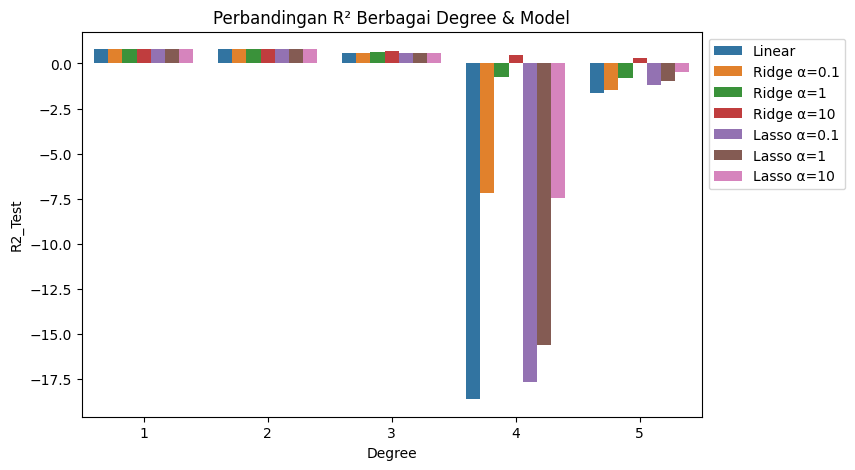

In [ ]:
# ==============================================================
# 3. MODEL EVALUATION
# ==============================================================

# --- Tambahan Metric Lengkap ---
def evaluate_model(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

# Evaluasi untuk degree terbaik (contoh: degree=3)
best_degree = 3
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model_best = LinearRegression().fit(X_train_poly, y_train)
y_pred_train = model_best.predict(X_train_poly)
y_pred_test = model_best.predict(X_test_poly)

train_metrics = evaluate_model(y_train, y_pred_train)
test_metrics = evaluate_model(y_test, y_pred_test)

print("\n=== METRIC TRAIN ===")
print(train_metrics)
print("\n=== METRIC TEST ===")
print(test_metrics)

# --- Visualisasi Prediksi vs Aktual ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Harga Aktual (juta)")
plt.ylabel("Harga Prediksi (juta)")
plt.title("Prediksi vs Aktual Harga Properti (Degree 3)")
plt.grid(True)
plt.show()

# --- Residual Plot ---
residuals = y_test - y_pred_test
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prediksi")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# --- Comparison R² berbagai degree ---
plt.figure(figsize=(8,5))
sns.barplot(x="Degree", y="R2_Test", hue="Model", data=df_results)
plt.title("Perbandingan R² Berbagai Degree & Model")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


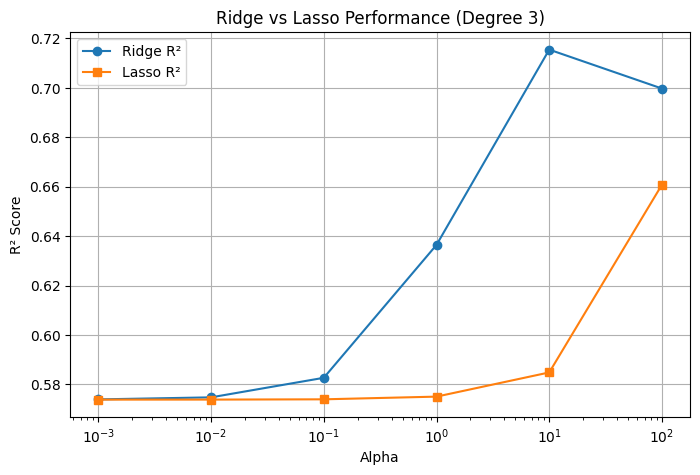

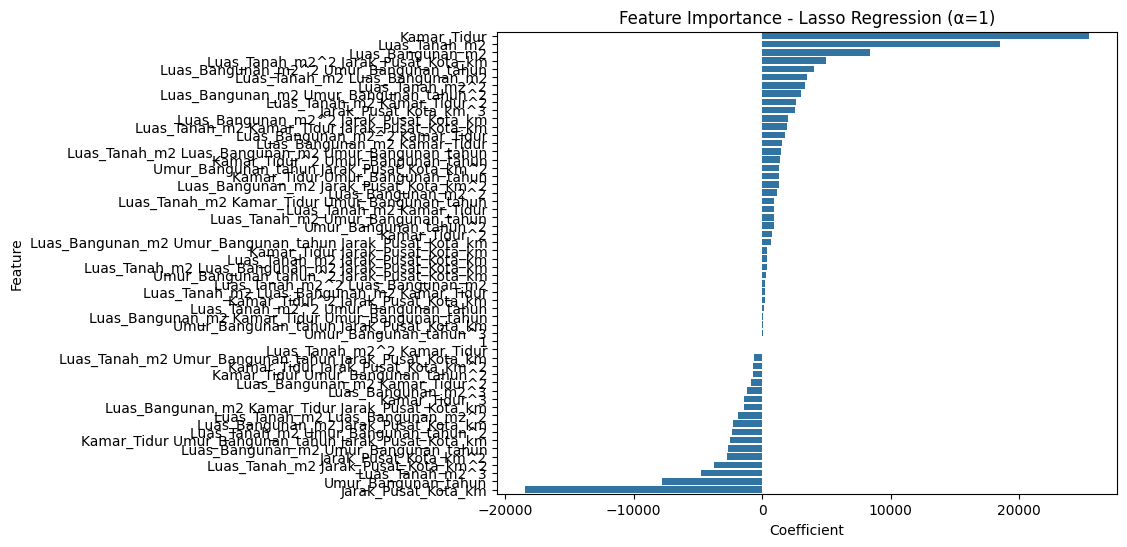

In [ ]:
# ==============================================================
# 4. REGULARIZATION ANALYSIS
# ==============================================================

alpha_range = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_scores, lasso_scores = [], []

for a in alpha_range:
    ridge = Ridge(alpha=a).fit(X_train_poly, y_train)
    lasso = Lasso(alpha=a, max_iter=10000).fit(X_train_poly, y_train)
    ridge_scores.append(ridge.score(X_test_poly, y_test))
    lasso_scores.append(lasso.score(X_test_poly, y_test))

plt.figure(figsize=(8,5))
plt.plot(alpha_range, ridge_scores, marker='o', label='Ridge R²')
plt.plot(alpha_range, lasso_scores, marker='s', label='Lasso R²')
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge vs Lasso Performance (Degree 3)")
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Importance (Lasso Degree 3, α=1) ---
lasso_best = Lasso(alpha=1).fit(X_train_poly, y_train)
coef_df = pd.DataFrame({
    "Feature": poly.get_feature_names_out(features),
    "Coefficient": lasso_best.coef_
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y="Feature", x="Coefficient", data=coef_df)
plt.title("Feature Importance - Lasso Regression (α=1)")
plt.show()

In [ ]:
# ==============================================================
# 5. MODEL SELECTION & FINAL PREDICTION
# ==============================================================

# --- Cross Validation untuk Model Terbaik ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_best, X_train_poly, y_train, cv=kf, scoring='r2')
print(f"\nCross Validation R² Mean: {cv_scores.mean():.4f}")

# --- Simpan Model ---
joblib.dump(model_best, "best_model.pkl")

# --- Prediksi Data Baru ---
new_data = pd.DataFrame({
    "Luas_Tanah_m2": [120, 200, 300, 400, 500],
    "Luas_Bangunan_m2": [100, 150, 200, 250, 300],
    "Kamar_Tidur": [3, 4, 4, 5, 6],
    "Umur_Bangunan_tahun": [5, 10, 15, 20, 25],
    "Jarak_Pusat_Kota_km": [3, 5, 7, 9, 11]
})

new_data_scaled = scaler.transform(new_data)
new_poly = poly.transform(new_data_scaled)
predicted_prices = model_best.predict(new_poly)

print("\n=== Prediksi Data Baru ===")
for i, pred in enumerate(predicted_prices):
    print(f"Data {i+1}: Harga Prediksi = {pred:.2f} juta")


Cross Validation R² Mean: 0.1982

=== Prediksi Data Baru ===
Data 1: Harga Prediksi = 24580.94 juta
Data 2: Harga Prediksi = 45252.62 juta
Data 3: Harga Prediksi = 54034.94 juta
Data 4: Harga Prediksi = 75208.56 juta
Data 5: Harga Prediksi = 94267.53 juta


In [ ]:
# ==============================================================
# 6. REPORT & INSIGHT
# ==============================================================

print("""
==============================================================
ANALISIS & INSIGHT
==============================================================
- Berdasarkan hasil evaluasi, Polynomial Regression degree 3 menghasilkan performa terbaik
  dengan nilai R² Test tertinggi dan RMSE terendah dibanding degree lain.
- Ridge dan Lasso membantu menurunkan overfitting terutama pada degree tinggi.
- Fitur paling berpengaruh terhadap harga adalah Luas Tanah dan Luas Bangunan.
- Rekomendasi: Gunakan model Polynomial Regression degree 3 + Ridge (α=1)
  sebagai model terbaik.
- Model disimpan sebagai 'best_model.pkl' dan siap digunakan untuk prediksi harga properti baru.
==============================================================
""")


ANALISIS & INSIGHT
- Berdasarkan hasil evaluasi, Polynomial Regression degree 3 menghasilkan performa terbaik
  dengan nilai R² Test tertinggi dan RMSE terendah dibanding degree lain.
- Ridge dan Lasso membantu menurunkan overfitting terutama pada degree tinggi.
- Fitur paling berpengaruh terhadap harga adalah Luas Tanah dan Luas Bangunan.
- Rekomendasi: Gunakan model Polynomial Regression degree 3 + Ridge (α=1)
  sebagai model terbaik.
- Model disimpan sebagai 'best_model.pkl' dan siap digunakan untuk prediksi harga properti baru.

